## 0. Import Modules and Data

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import pandas_datareader.data as web
import datetime as dt

In [2]:
import Portfolio as port # This is from the Portfolio.py file with the different classes defined

## 1. Set-up Portfolio Strategy

In [3]:
# Define start date and end date

start_date = '2015-01-01'

end_date = '2020-01-05'

In [4]:
# Define Shares

# Provide the name of the ticker and type (Equity or Bond)

#VOO and BND are Vanguard ETFs which are proxies for individual stocks/bonds

voo = port.Share('VOO', 'Equity', start_date,end_date)
bnd = port.Share('BND', 'Bond', start_date, end_date)

In [5]:
voo.get_value('2019-01-01')

229.99

In [6]:
voo.get_value('2019-10-31')

278.55

In [7]:
# Need a way to group the different shares together

shares_list = [voo, bnd]

shares_dict = {}

for share in shares_list:
    shares_dict[share] = share.type


In [8]:
shares_dict

{<Portfolio.Share at 0x7f59443cf048>: 'Equity',
 <Portfolio.Share at 0x7f59443cfbe0>: 'Bond'}

In [24]:
# Define Strategy

# Provide the equity distribution, the bond distriubtion, cash distribution, and the threshold
strat = port.Strategy(50,50,0,1)

In [25]:
# Run portfolio with set start and end dates

portfolio = port.Portfolio(shares_dict)

portfolio.initial_buy(500, strat, start_date)

In [26]:
portfolio.get_asset_values(start_date)

In [27]:
portfolio.asset_split

{'Equities': 50.0, 'Bonds': 50.0, 'Cash': 0.0}

In [28]:
# Run the portfolio over a series of months

time_period = pd.date_range(pd.to_datetime(start_date),pd.to_datetime(end_date))

for day in time_period:
    portfolio.reinvest_divs(day)
    portfolio.get_asset_values(day)
    if portfolio.asset_split['Equities'] > strat.equity_distribution+strat.threshold:
        sell_amt = (portfolio.asset_values['Equities']+portfolio.asset_values['Bonds'])*((portfolio.asset_split['Equities']-strat.equity_distribution)/100)
        sell_amt_per = sell_amt/len(portfolio.equities)
        for share in portfolio.equities: # sell equities and buy more bonds
            portfolio.sell(share, sell_amt_per, day)
        for share in portfolio.bonds:
            portfolio.buy(share, sell_amt_per, day)
               
    if portfolio.asset_split['Bonds'] > strat.bond_distribution+strat.threshold:
        sell_amt = (portfolio.asset_values['Equities']+portfolio.asset_values['Bonds'])*(portfolio.asset_split['Bonds']-strat.bond_distribution)
        sell_amt_per = sell_amt/len(portfolio.bonds)
        for share in portfolio.bonds: # sell bonds and buy more equities
            portfolio.sell(share, sell_amt_per, day)
        for share in portfolio.bonds:
            portfolio.buy(share, sell_amt_per, day)
        
    

In [29]:
# Create a dataframe with the historical data

portfolio_history = portfolio.get_hist_df()
portfolio_history['Date'] = pd.to_datetime(portfolio_history['Date']) # Convert date to datetime object
portfolio_history.set_index('Date', inplace = True)
portfolio_history.tail()

,Total Value,Equities,Bonds
Date,,,
2020-01-01,715.957431,362.850082,353.107349
2020-01-02,715.957431,362.850082,353.107349
2020-01-03,714.568308,360.199411,354.368897
2020-01-04,714.568308,360.199411,354.368897
2020-01-05,714.568308,360.199411,354.368897


<AxesSubplot:xlabel='Date'>

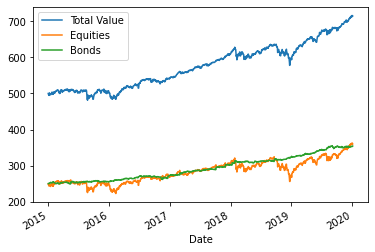

In [30]:
# Plot the Total value, value of equities, and value of bonds over the length of the timeframe

# This represents the performance of a portfolio with a 50% Equity-50% Bond allocation

portfolio_history[['Total Value', 'Equities','Bonds']].plot()

## 2. Compare Different Allocation Rates

In [42]:
# Create an empty DataFrame for different allocation rates

allocation_df = pd.DataFrame()

# Create an empty DataFrame for different allocation ROI

allocation_roi_df = pd.DataFrame()

In [102]:
# Create an empty DataFrame for reporting the standard deviation in each strategy/year

std_df = pd.DataFrame()

In [103]:
# Create a loop for different strategies (different allocation proportions)

# This is largely the same as above, however, the strat (strategy) will change in each iteration

ini_amount = 500
 
for i in range(0,100,5):
    strat = port.Strategy(i,100-i,0,1) 
    
    portfolio = port.Portfolio(shares_dict)

    portfolio.initial_buy(ini_amount, strat, start_date)
    
    time_period = pd.date_range(pd.to_datetime(start_date),pd.to_datetime(end_date))

    for day in time_period:
        portfolio.reinvest_divs(day)
        portfolio.get_asset_values(day)
        if portfolio.asset_split['Equities'] > strat.equity_distribution+strat.threshold:
            sell_amt = (portfolio.asset_values['Equities']+portfolio.asset_values['Bonds'])*((portfolio.asset_split['Equities']-strat.equity_distribution)/100)
            sell_amt_per = sell_amt/len(portfolio.equities)
            for share in portfolio.equities: # sell equities and buy more bonds
                portfolio.sell(share, sell_amt_per, day)
            for share in portfolio.bonds:
                portfolio.buy(share, sell_amt_per, day)

        if portfolio.asset_split['Bonds'] > strat.bond_distribution+strat.threshold:
            sell_amt = (portfolio.asset_values['Equities']+portfolio.asset_values['Bonds'])*(portfolio.asset_split['Bonds']-strat.bond_distribution)
            sell_amt_per = sell_amt/len(portfolio.bonds)
            for share in portfolio.bonds: # sell bonds and buy more equities
                portfolio.sell(share, sell_amt_per, day)
            for share in portfolio.bonds:
                portfolio.buy(share, sell_amt_per, day)
    portfolio_history = portfolio.get_hist_df()
    portfolio_history['Date'] = pd.to_datetime(portfolio_history['Date']) # Convert date to datetime object
    portfolio_history.set_index('Date', inplace = True) 
    
    # Create a new column of the allocation dataframe based on the total value of the most recent portfolio simulation
    allocation_df[str(i)+'% Equities:'+str(100-i)+'% Bonds'] = portfolio_history['Total Value']
    
    # Loop through each year to calculate a ROI in each year and Standard Deviation 
    
    portfolio_history['Year'] = portfolio_history.index.strftime('%Y')
    
    years = list(portfolio_history['Year'].unique())
    
    for year in years:
        subset = portfolio_history[portfolio_history['Year']==year]
        allocation_roi_df.at[year,str(i)+'% Equities:'+str(100-i)+' % Bonds'] = ((subset['Total Value'].iat[-1]/subset['Total Value'].iat[0])-1)*100
        std_df.at[year,str(i)+'% Equities:'+str(100-i)+' % Bonds'] = subset['Total Value'].std()
    allocation_roi_df.at['Period Total',str(i)+'% Equities:'+str(100-i)+' % Bonds'] = ((portfolio_history['Total Value'].iat[-1]/portfolio_history['Total Value'].iat[0])-1)*100
    std_df.at['Period Total',str(i)+'% Equities:'+str(100-i)+' % Bonds'] = portfolio_history['Total Value'].std()
    # Get standard deviation for each year/strategy
    
 

<AxesSubplot:xlabel='Date'>

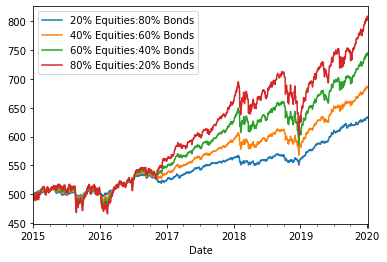

In [36]:
allocation_df[['20% Equities:80% Bonds','40% Equities:60% Bonds','60% Equities:40% Bonds','80% Equities:20% Bonds']].plot()

In [72]:
allocation_roi_df

,0% Equities:100 % Bonds,5% Equities:95 % Bonds,10% Equities:90 % Bonds,15% Equities:85 % Bonds,20% Equities:80 % Bonds,25% Equities:75 % Bonds,30% Equities:70 % Bonds,35% Equities:65 % Bonds,40% Equities:60 % Bonds,45% Equities:55 % Bonds,50% Equities:50 % Bonds,55% Equities:45 % Bonds,60% Equities:40 % Bonds,65% Equities:35 % Bonds,70% Equities:30 % Bonds,75% Equities:25 % Bonds,80% Equities:20 % Bonds,85% Equities:15 % Bonds,90% Equities:10 % Bonds,95% Equities:5 % Bonds
2015,0.218626,0.273435,0.328244,0.383053,0.437862,0.492671,0.584348,0.636731,0.689152,0.741940,0.797053,0.851559,0.908389,0.965585,1.028476,1.040762,1.095572,1.150381,1.205190,1.259999
2016,2.587218,3.184265,3.786813,4.348741,4.929391,5.520848,6.043585,6.629010,7.222337,7.818013,8.428890,9.014540,9.615362,10.227456,10.822423,11.506959,12.112548,12.729853,13.371337,13.959125
2017,3.691745,4.613491,5.444126,6.325657,7.175629,8.036254,8.918145,9.803572,10.686046,11.585973,12.471108,13.397852,14.309808,15.235800,16.168599,17.096929,18.065387,19.012808,19.950952,20.963172
2018,0.399563,0.098906,-0.073633,-0.341283,-0.458312,-0.708085,-1.070154,-1.279104,-1.622218,-1.895153,-2.030043,-2.454619,-2.741172,-3.049134,-3.278649,-3.636598,-3.938433,-4.232325,-4.502496,-4.926519
2019,8.615056,9.752188,10.650205,11.685000,12.552129,13.576834,14.758023,15.754691,16.930999,18.034645,18.976087,20.287908,21.438156,22.636861,23.738357,25.025217,26.239241,27.467102,28.669020,30.088455
2020,0.357270,0.301886,0.240486,0.194103,0.135325,0.080188,0.028791,-0.033622,-0.082840,-0.137380,-0.194023,-0.246149,-0.300378,-0.354503,-0.404179,-0.460475,-0.512957,-0.576525,-0.626441,-0.684159
Period Total,17.000328,19.566755,21.955314,24.430453,26.896683,29.435010,32.037200,34.667888,37.361456,40.117462,42.913662,45.777220,48.682505,51.676951,54.714501,57.797106,60.967322,64.155941,67.426343,70.757296


In [ ]:
## 3. Analyse Volatility

In [104]:
std_df

,0% Equities:100 % Bonds,5% Equities:95 % Bonds,10% Equities:90 % Bonds,15% Equities:85 % Bonds,20% Equities:80 % Bonds,25% Equities:75 % Bonds,30% Equities:70 % Bonds,35% Equities:65 % Bonds,40% Equities:60 % Bonds,45% Equities:55 % Bonds,50% Equities:50 % Bonds,55% Equities:45 % Bonds,60% Equities:40 % Bonds,65% Equities:35 % Bonds,70% Equities:30 % Bonds,75% Equities:25 % Bonds,80% Equities:20 % Bonds,85% Equities:15 % Bonds,90% Equities:10 % Bonds,95% Equities:5 % Bonds
2015,3.277656,3.029254,2.935912,3.012081,3.245849,3.606701,3.945337,4.461794,5.027949,5.627026,6.246685,6.886082,7.535661,8.193720,8.853427,9.658039,10.337256,11.020428,11.706864,12.396022
2016,8.836834,9.224692,9.761782,10.424354,11.185307,12.027358,12.773275,13.727919,14.731020,15.773024,16.843694,17.941436,19.058647,20.198488,21.339182,22.704892,23.887967,25.082713,26.293271,27.487891
2017,7.242286,8.216836,9.146438,10.144082,11.188730,12.254838,13.387686,14.546961,15.723672,16.940761,18.162211,19.451127,20.742818,22.068244,23.421983,24.777168,26.208308,27.625426,29.090577,30.629422
2018,3.449771,3.498633,3.786160,4.362841,5.096592,5.961163,7.068197,8.080240,9.321912,10.542703,11.619484,13.149161,14.529898,15.894757,17.400765,18.922247,20.515432,22.160688,23.924619,25.725789
2019,16.989370,17.881960,18.681932,19.616551,20.506505,21.540432,22.732844,23.854939,25.162040,26.466448,27.688554,29.257302,30.743357,32.325010,33.859343,35.609153,37.344505,39.140003,40.961947,43.021149
2020,1.140686,0.985540,0.801269,0.660157,0.469649,0.284018,0.104077,0.124042,0.311886,0.527892,0.760854,0.985119,1.226775,1.477790,1.719467,1.999124,2.272914,2.606854,2.890439,3.221429
Period Total,22.304900,25.639281,29.041663,32.619629,36.434073,40.313220,44.167499,48.317584,52.479124,56.812991,61.329961,65.729855,70.306972,75.027201,79.804327,84.725386,89.695822,94.737085,99.878432,105.001148


In [ ]:
# https://www.investopedia.com/terms/p/portfolio-variance.asp

In [ ]:
# Look for biggest monthly/weekly decrease in portfolio value

In [ ]:
# Get the value a few days later

portfolio.get_value('2018-05-01')

In [ ]:
portfolio.get_asset_values('2018-05-01')

In [ ]:
portfolio.asset_values

In [ ]:
for share in portfolio.shares:
    print(share.div.index)

In [ ]:
portfolio.reinvest_divs('2018-05-01')

In [ ]:
# import sys
# !{sys.executable} -m pip install pandas_datareader

In [ ]:
## This is useful:
#https://jakevdp.github.io/PythonDataScienceHandbook/03.11-working-with-time-series.html

In [ ]:
bnd = web.DataReader('BND', 'yahoo', start='2015-10-30', end='2020-10-30')

In [ ]:
sp = web.DataReader('VOO', 'yahoo', start='2015-10-30', end='2020-10-30')

In [ ]:
sp.head(3)

In [ ]:
bnd.head(3)

In [ ]:
bnd.loc['2017-07-07']['High']

In [ ]:
# Import dividend records
bnd_div = web.DataReader('BND', 'yahoo-dividends', start='2015-10-30', end='2020-10-30')
sp_div = web.DataReader('VOO', 'yahoo-dividends', start='2015-10-30', end='2020-10-30')

In [ ]:
bnd_div.head(3)

In [ ]:
sp_div.head(3)

In [ ]:
sp_div.value.loc['2020-09-29']

In [ ]:
sp_div[sp_div.index < pd.to_datetime('2016-01-01')]

In [ ]:
sp_div.index

In [ ]:
str('sp')+str('_div')

In [ ]:
Assets = {}
Assets['Bonds'] = bnd
Assets['Equities'] = sp

In [ ]:
Dividends

In [ ]:
# Maybe it is worth merging the dividend and share price files together for easier reference?
# Or build a dictionary to allow easy mapping?

## 1. Calculate Value Given a Start and End Date

In [ ]:
start_date = '2015-11-20'
end_date = 

In [ ]:
def calc_value(share, divs, start, end, initial_value):
    # Take the average of the day's high and low for starting share price
    num_shares = initial_value/np.mean([share.loc[start]['Low'],share.loc[start]['High']])
    divs = divs[(divs.index <= pd.to_datetime(end)) & (divs.index >= pd.to_datetime(start))]
    for date in divs.index:
        price = np.mean([share.High.loc[date], share.Low.loc[date]])
        div_value = divs.value.loc[date]
        num_shares += div_value/price
    output = {}
    output['Value'] = num_shares*np.mean([share.loc[end]['Low'],share.loc[end]['High']])
    output['ROI'] = output['Value']-initial_value
    return(output)
    
    # Will need to factor in other actions later, but this will work for now
    
    


In [ ]:
calc_value(sp,sp_div, '2015-11-20', '2017-11-20',100)

In [ ]:
calc_value(bnd,bnd_div, '2015-11-20', '2017-11-20',100)

In [ ]:
sp.Close.plot()

In [ ]:
bnd.Close.plot()

In [ ]:
# Identify the ROI with different asset distributions

In [ ]:
class Share:

    def __init__(self, name, asset_type):
        """Initialize attributes."""
        self.name = name
        self.type = asset_type
        #self.amount = amount
        
    def get_value(self, date):
        df = web.DataReader(self.name, 'yahoo', start=date, end=date)
        return round(df.loc[date,'Close'],2)
    

In [ ]:
bnd = Share('BND','Bond')

In [ ]:
sp = Share('VOO','Equity')

In [ ]:
class Strategy:
    
    def __init__(self,equity_distribution, bond_distribution, cash_distribution, threshold):
        self.equity_distribution = equity_distribution
        self.bond_distribution = bond_distribution
        self.cash_distribution = 100-(equity_distribution+bond_distribution)
        self.threshold = threshold
    

In [ ]:
class Portfolio:
    
    def __init__(self):
        self.shares = {}
        self.log = {}
        self.cash_bal = 0
        self.asset_split = {'Equities': None,'Bonds': None,'Cash': None}
        self.asset_values = {'Equities': None,'Bonds': None,'Cash': None}
        
    def buy(self, share, amount, date):
        purchase_price = share.get_value(date)
        shares = amount/purchase_price
        # Record the transaction
        self.log[len(self.log)] = ['Buy',share,amount,purchase_price,shares,date]
        # Add the number of shares
        if share in self.shares:
            self.shares[share] += shares
        elif share not in self.shares:
            self.shares[share] = shares
            
    def sell(self, share, amount, date):
        sell_price = share.get_value(date)
        shares = amount/sell_price
        # Record the transaction
        self.log[len(self.log)] = ['Sell',share,amount,sell_price,shares,date]
        # Add the number of shares
        if share in self.shares:
            self.shares[share] -= shares
        elif share not in self.shares:
            self.shares[share] = shares
        cash_bal += amount
        
            
    def get_value(self,date):
        value = self.cash_bal
        # Iterate through the 'shares' attribute and get the current value for each 'Share' object
        for share in self.shares:
            value += share.get_value(date)*self.shares[share]
        return(value)
    
    def get_asset_values(self,date):
        bond_val = 0
        eq_val = 0
        for share in self.shares:
            if share.type == 'Bond':
                bond_val += share.get_value(date)*self.shares[share]
            elif share.type == 'Equity':
                eq_val += share.get_value(date)*self.shares[share]
        total = bond_val+eq_val+self.cash_bal
        self.asset_values = {'Equities': eq_val,'Bonds': bond_val,'Cash': self.cash_bal}
        self.asset_split = {'Equities': (eq_val/total)*100,'Bonds': (bond_val/total)*100,'Cash': (self.cash_bal/total)*100}
            
        
    

In [ ]:
portfolio = Portfolio()

In [ ]:
portfolio.get_value)

In [ ]:
# Calculate portfolio value

start_date = '2015-11-20'
end_date = '2020-11-20'

portfolio.buy(sp,750,start_date)
portfolio.buy(bnd,250,start_date)

portfolio.get_value(end_date)

In [ ]:
bond = web.DataReader('BND', 'yahoo', start='2015-10-30', end='2020-10-30')

In [ ]:
dates = list(bond.index)

In [ ]:
dates = [x.strftime('%Y-%m-%d') for x in dates]

In [ ]:
# Deploy balancing strategy

strategy = Strategy(75,25,0,1)

# Initial Purchase (manually allocated proportions)
portfolio = Portfolio() 
portfolio.buy(sp,750,start_date)
portfolio.buy(bnd,250,start_date)

for date in dates:
    portfolio.get_asset_values(date)
    if portfolio.asset_split['Equities'] > strategy.equity_distribution+strategy.threshold:
        amount_to_sell = (portfolio.asset_split['Equities']-strategy.equity_distribution)*portfolio.asset_values['Equities']
        portfolio.sell(sp,amount_to_sell,date)
        portfolio.buy(bnd,amount_to_sell,date)
        

    

In [ ]:
portfolio.get_asset_values('2019-10-29')

In [ ]:
portfolio.asset_split['Equities']